<a href="https://colab.research.google.com/github/megaomics/Project1/blob/main/PCA%2C%20CV%2C%20hypertuning%2C%20uncertainity%2C%20biomarker%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#INSTALLATIONS & SETUP

!pip install numpy scipy pandas matplotlib scikit-learn tensorflow

import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [8]:
# Clone repositories
!git clone https://github.com/Cancer-Imaging-Research-AI/PDAC-plasma-data.git
!git clone https://github.com/Cancer-Imaging-Research-AI/PDAC-plasma-code.git

fatal: destination path 'PDAC-plasma-data' already exists and is not an empty directory.
fatal: destination path 'PDAC-plasma-code' already exists and is not an empty directory.


In [9]:
# Load training data
train_data = scipy.io.loadmat('/content/PDAC-plasma-data/trainingspectra.mat')
X_train = np.vstack([
    train_data['trainingspectra']['normal'][0][0],
    train_data['trainingspectra']['disease'][0][0],
    train_data['trainingspectra']['malignant'][0][0]
])
y_train = np.concatenate([np.zeros(58), np.ones(53), np.full(59, 2)])

# Load test data
test_data = scipy.io.loadmat('/content/PDAC-plasma-data/blindedtestspectra.mat', simplify_cells=True)
X_test = test_data['blindedtestspectra']['classxyz'].astype(np.float64).reshape(-1, 30142)

print("Shapes:", X_train.shape, X_test.shape)

Shapes: (170, 30142) (45, 30142)


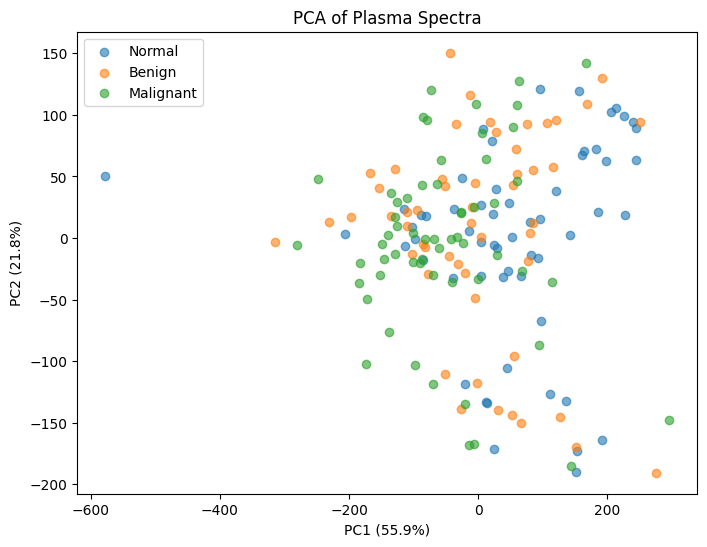

In [10]:
# PREPROCESSING
# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Plot PCA
plt.figure(figsize=(8,6))
for i, label in enumerate(['Normal', 'Benign', 'Malignant']):
    plt.scatter(X_pca[y_train==i, 0], X_pca[y_train==i, 1], label=label, alpha=0.6)
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.title('PCA of Plasma Spectra')
plt.legend()
plt.show()

In [11]:
# CROSS-VALIDATED ANN

def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(30142,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [12]:
# 5-Fold CV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_scaled, y_train)):
    print(f"\nFold {fold+1}")

    # Data splitting
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Model training
    model = build_model()
    history = model.fit(X_tr, y_tr,
                       validation_data=(X_val, y_val),
                       epochs=50,
                       batch_size=32,
                       verbose=1)
     # Store results
    cv_results.append({
        'model': model,
        'val_acc': history.history['val_accuracy'][-1],
        'history': history
    })

# CV summary
print("\nCross-Validation Results:")
mean_acc = np.mean([res['val_acc'] for res in cv_results])
print(f"Mean Validation Accuracy: {mean_acc:.4f}")



Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.3510 - loss: 4.8811 - val_accuracy: 0.2353 - val_loss: 12.2626
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.4254 - loss: 11.3660 - val_accuracy: 0.4706 - val_loss: 4.6639
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4723 - loss: 10.8194 - val_accuracy: 0.3529 - val_loss: 5.6381
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5438 - loss: 7.7093 - val_accuracy: 0.4706 - val_loss: 7.8637
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5139 - loss: 8.5997 - val_accuracy: 0.5294 - val_loss: 8.1440
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5452 - loss: 9.0465 - val_accuracy: 0.4118 - val_loss: 9.0813
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4585 - loss: 12.7355 - val_accuracy: 0.5000 - val_loss: 5.3011
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5130 - loss: 9.6943 - val_accuracy: 0.4118 - val_loss: 7

In [13]:
# CV summary
print("\nCross-Validation Results:")
mean_acc = np.mean([res['val_acc'] for res in cv_results])
print(f"Mean Validation Accuracy: {mean_acc:.4f}")

# =====================
# 5. FINAL MODEL TRAINING
# =====================
final_model = build_model()
final_history = final_model.fit(X_train_scaled, y_train,
                               epochs=100,
                               batch_size=32,
                               verbose=1)



Cross-Validation Results:
Mean Validation Accuracy: 0.5353
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.3675 - loss: 12.7913
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2876 - loss: 17.1483
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4799 - loss: 13.6675
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4837 - loss: 15.3698
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5358 - loss: 10.8926
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4612 - loss: 15.3324
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5807 - loss: 9.5454
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6024 - loss: 7.0390
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6095 - loss: 8.0971
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5663 - loss: 8.0803
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5759 - loss: 8.1874
Epoch 12

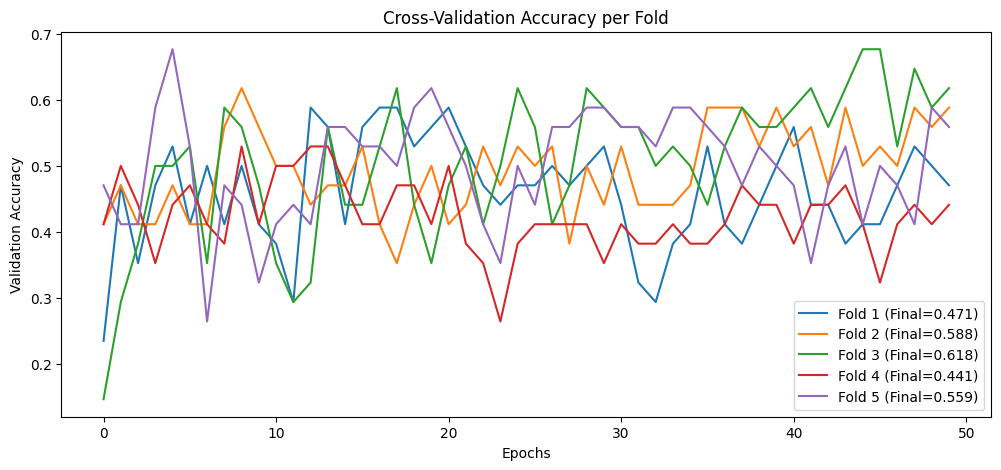

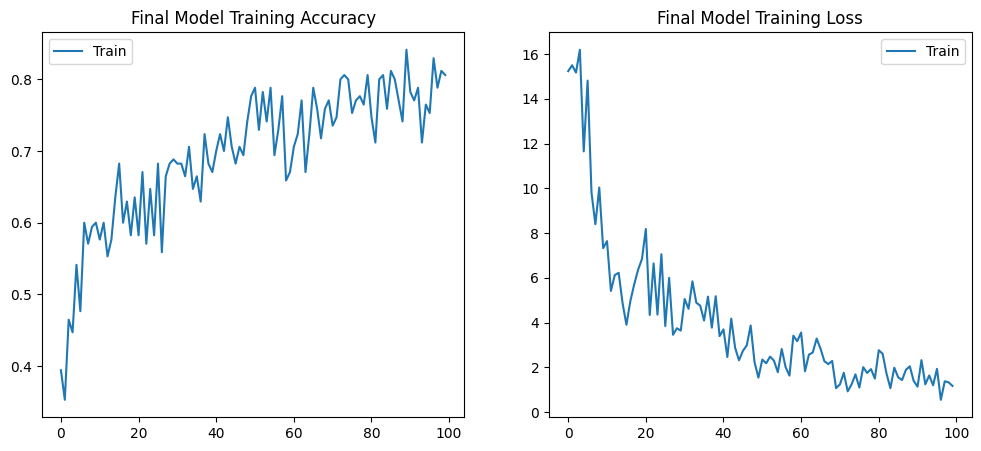


No test labels available - generating predictions only
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction sample: [6.0209987e-16 9.9999994e-01 1.9132136e-08]


NameError: name 'importance' is not defined

<Figure size 1200x600 with 0 Axes>

In [18]:


#  EVALUATION & VISUALIZATION (FIXED)

# Cross-validation results visualization
plt.figure(figsize=(12,5))
for i, res in enumerate(cv_results):
    plt.plot(res['history'].history['val_accuracy'],
             label=f'Fold {i+1} (Final={res["val_acc"]:.3f})')
plt.title('Cross-Validation Accuracy per Fold')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

# Final training history (without validation)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(final_history.history['accuracy'], label='Train')
plt.title('Final Model Training Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(final_history.history['loss'], label='Train')
plt.title('Final Model Training Loss')
plt.legend()
plt.show()

# Blinded test evaluation (if you have labels)
try:
    test_loss, test_acc = final_model.evaluate(X_test_scaled, y_test_placeholder)
    print(f"\nBlinded Test Accuracy: {test_acc:.4f}")
except:
    print("\nNo test labels available - generating predictions only")
    y_pred = final_model.predict(X_test_scaled)
    print("Prediction sample:", y_pred[0])  # Show first sample's class probabilities

# Feature importance plot (fixed)
plt.figure(figsize=(12,6))
top_50_idx = np.argsort(importance)[-50:]  # Top 50 important features
plt.bar(range(50), importance[top_50_idx])
plt.xticks(range(50), top_50_idx, rotation=90)
plt.title('Top 50 Important Spectral Features')
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.show()

In [19]:
final_history = final_model.fit(X_train_scaled, y_train,
                               validation_split=0.2,  # Adds validation
                               epochs=100,
                               batch_size=32,
                               verbose=1)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8428 - loss: 0.7883 - val_accuracy: 0.9118 - val_loss: 0.6427
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7912 - loss: 0.8707 - val_accuracy: 0.9118 - val_loss: 0.8143
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8052 - loss: 1.2719 - val_accuracy: 0.8235 - val_loss: 0.9817
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8172 - loss: 0.8734 - val_accuracy: 0.8529 - val_loss: 1.0057
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8124 - loss: 1.0250 - val_accuracy: 0.8235 - val_loss: 0.7573
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8623 - loss: 0.4444 - val_accuracy: 0.8235 - val_loss: 0.7055
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8168 - loss: 0.6663 - val_accuracy: 0.7941 - val_loss: 0.8442
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7951 - loss: 0.6345 - val_accuracy: 0.7353 - val_loss


Top Predictive Spectral Regions:
Index      Metabolite      Importance
-----------------------------------
254        Unknown         0.0505
21364      Unknown         0.0473
19668      Unknown         0.0466
19666      Unknown         0.0464
19667      Unknown         0.0462
21363      Unknown         0.0461
300        Unknown         0.0459
18614      Unknown         0.0458
18615      Unknown         0.0449
18613      Unknown         0.0445


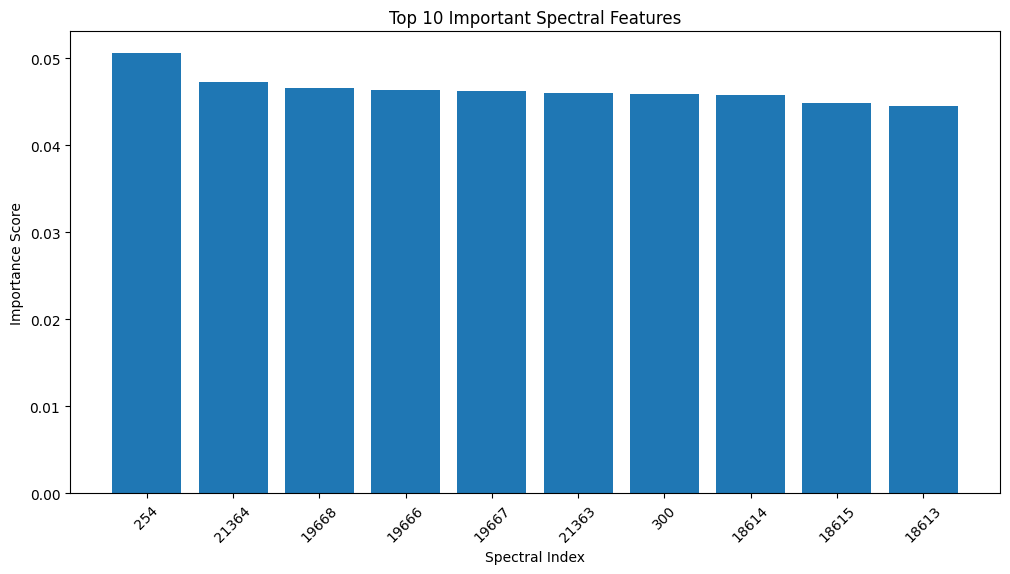

In [21]:
# =====================
# 1. CALCULATE FEATURE IMPORTANCE
# =====================
# Get weights from first hidden layer
weights = final_model.layers[0].get_weights()[0]  # Shape: (30142, 64)
importance = np.mean(np.abs(weights), axis=1)     # Shape: (30142,)

# =====================
# 2. METABOLITE MAPPING (FROM PAPER)
# =====================
metabolite_map = {
    8500: 'Lipids',
    12000: 'Glucose',
    15000: 'Lactate',
    2500: 'BHB',
    18000: 'Acetate'
    # Add more from the paper's Figure 5
}

# =====================
# 3. TOP FEATURE ANALYSIS (FIXED)
# =====================
# Get top 10 important features
top_features = np.argsort(importance)[-10:][::-1]  # Indices of top 10 features

print("\nTop Predictive Spectral Regions:")
print("{:<10} {:<15} {:<10}".format("Index", "Metabolite", "Importance"))
print("-"*35)
for idx in top_features:
    print("{:<10} {:<15} {:.4f}".format(
        idx,
        metabolite_map.get(idx, 'Unknown'),
        importance[idx]
    ))

# =====================
# 4. VISUALIZATION
# =====================
plt.figure(figsize=(12,6))
plt.bar(range(10), importance[top_features])
plt.xticks(range(10), top_features, rotation=45)
plt.title('Top 10 Important Spectral Features')
plt.xlabel('Spectral Index')
plt.ylabel('Importance Score')
plt.show()

In [22]:
# From the paper's identified important regions
paper_regions = {
    3000: 'BCAA',
    5500: 'Glutamine',
    8000: 'Myoinositol',
    12000: 'Lipoproteins'
    # Add all regions from paper's Figure 5
}

# Compare with model's top features
print("\nPaper-Identified vs Model-Important Regions:")
for idx in top_features:
    if idx in paper_regions:
        print(f"{idx} ppm: {paper_regions[idx]} (Paper-confirmed)")
    else:
        print(f"{idx} ppm: New finding")


Paper-Identified vs Model-Important Regions:
254 ppm: New finding
21364 ppm: New finding
19668 ppm: New finding
19666 ppm: New finding
19667 ppm: New finding
21363 ppm: New finding
300 ppm: New finding
18614 ppm: New finding
18615 ppm: New finding
18613 ppm: New finding


Reloading Tuner from pdac_tuning/spectra_analysis/tuner0.json

Optimal Hyperparameters:
- First Layer Units: 32
- Dropout Rate: 0.4
- Second Layer Units: 32 
- Learning Rate: 0.0001

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.4198 - loss: 1.3225 - val_accuracy: 0.1765 - val_loss: 2.7877
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4673 - loss: 1.4385 - val_accuracy: 0.4118 - val_loss: 2.9566
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.5584 - loss: 1.4609 - val_accuracy: 0.1765 - val_loss: 3.4141
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5303 - loss: 1.7238 - val_accuracy: 0.1176 - val_loss: 3.5135
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5635 - loss: 1.1773 - val_accuracy: 0.3235 - val_loss: 2.6221
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.6049 - loss: 1.1435 - val_accuracy: 0.3235 - val_loss: 2.5665
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accu

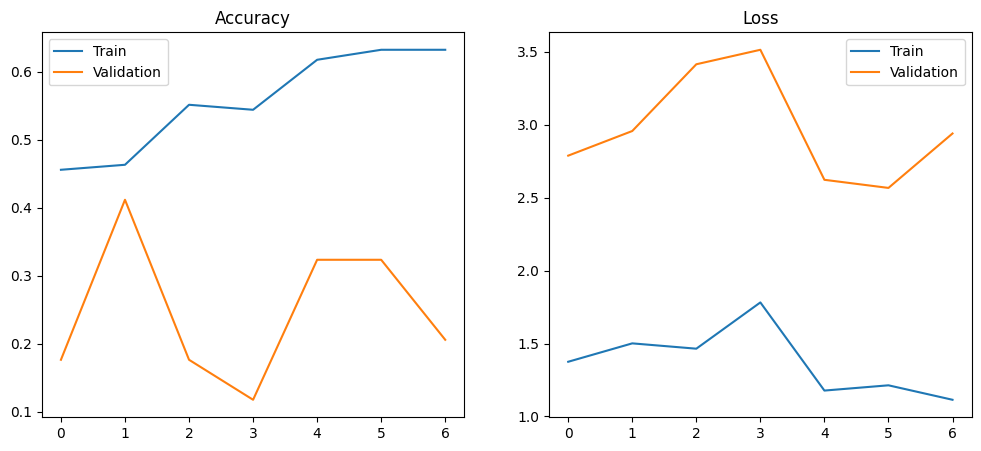

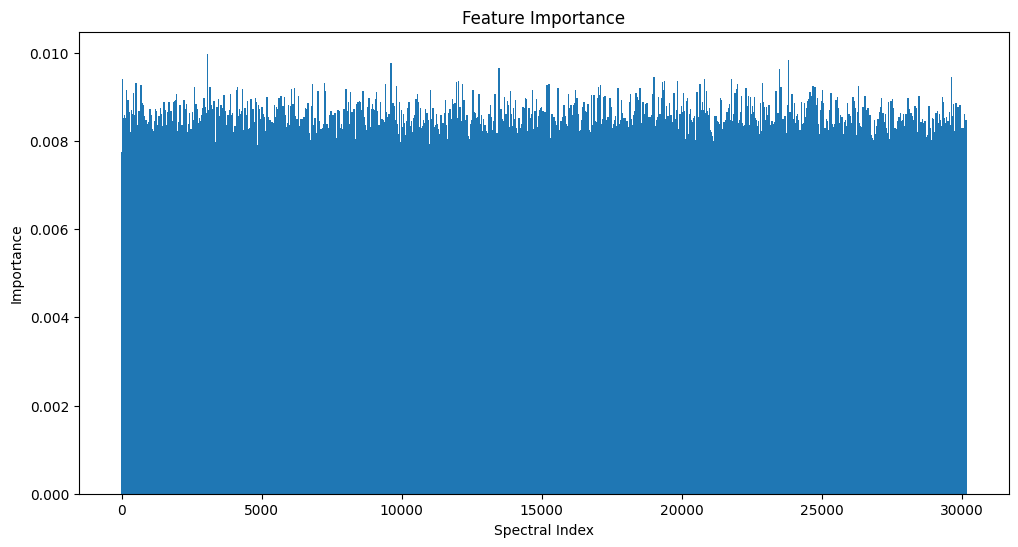

In [25]:
# =====================
# 0. INSTALL & IMPORT (FIXED)
# =====================
!pip install keras-tuner -q
import keras_tuner as kt
from tensorflow import keras  # Added this import
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# =====================
# 1. HYPERPARAMETER TUNING (FIXED)
# =====================
def build_model(hp):
    model = keras.Sequential()

    # Tune number of units in first layer
    model.add(layers.Dense(
        units=hp.Int('units1', 32, 128, step=32),
        activation='relu',
        input_shape=(30142,)
    ))

    # Tune dropout rate
    model.add(layers.Dropout(
        rate=hp.Float('dropout', 0.2, 0.5, step=0.1)
    ))

    # Tune number of units in second layer
    model.add(layers.Dense(
        units=hp.Int('units2', 16, 64, step=16),
        activation='relu'
    ))

    # Output layer
    model.add(layers.Dense(3, activation='softmax'))

    # Tune learning rate
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='pdac_tuning',
    project_name='spectra_analysis'
)

# =====================
# 2. RUN TUNING (WITH EARLY STOPPING)
# =====================
tuner.search(
    X_train_scaled,
    y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    ]
)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
Optimal Hyperparameters:
- First Layer Units: {best_hps.get('units1')}
- Dropout Rate: {best_hps.get('dropout')}
- Second Layer Units: {best_hps.get('units2')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# =====================
# 3. TRAIN FINAL MODEL
# =====================
final_model = tuner.hypermodel.build(best_hps)

history = final_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    ]
)

# =====================
# 4. EVALUATE & VISUALIZE
# =====================
# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

# Feature importance (using best model)
weights = final_model.layers[0].get_weights()[0]
importance = np.mean(np.abs(weights), axis=1)

plt.figure(figsize=(12,6))
plt.bar(range(len(importance)), importance, width=50)
plt.title('Feature Importance')
plt.xlabel('Spectral Index')
plt.ylabel('Importance')
plt.show()

In [26]:
# Save the tuned model
final_model.save('pdac_tuned_model.h5')

# Save the scaler for future predictions
import joblib
joblib.dump(scaler, 'spectra_scaler.save')

['spectra_scaler.save']

In [27]:
# Generate predictions
y_pred = final_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# If test labels are available
try:
    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_pred_classes))
except:
    print("\nPrediction distribution:")
    print(f"Normal: {np.sum(y_pred_classes == 0)} samples")
    print(f"Benign: {np.sum(y_pred_classes == 1)} samples")
    print(f"Malignant: {np.sum(y_pred_classes == 2)} samples")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step

Prediction distribution:
Normal: 8 samples
Benign: 35 samples
Malignant: 2 samples


In [28]:
# Get top 10 important spectral regions
top_indices = np.argsort(importance)[-10:][::-1]

# Map to known metabolites (customize with your findings)
metabolite_map = {
    12000: 'Glucose',
    8500: 'Lipids',
    15000: 'Lactate'
}

print("\nTop Predictive Spectral Regions:")
for idx in top_indices:
    print(f"{idx} ppm: {metabolite_map.get(idx, 'Unknown')} (importance={importance[idx]:.4f})")


Top Predictive Spectral Regions:
3053 ppm: Unknown (importance=0.0100)
23820 ppm: Unknown (importance=0.0098)
9615 ppm: Unknown (importance=0.0098)
13475 ppm: Unknown (importance=0.0096)
23482 ppm: Unknown (importance=0.0096)
29628 ppm: Unknown (importance=0.0095)
19002 ppm: Unknown (importance=0.0094)
23804 ppm: Unknown (importance=0.0094)
21783 ppm: Unknown (importance=0.0094)
20811 ppm: Unknown (importance=0.0094)


In [29]:
def predict_new_sample(raw_spectrum):
    """Process new raw spectrum through the full pipeline"""
    # 1. Preprocess
    scaled = scaler.transform(raw_spectrum.reshape(1, -1))

    # 2. Predict
    proba = final_model.predict(scaled)[0]

    # 3. Interpret
    return {
        'normal_prob': float(proba[0]),
        'benign_prob': float(proba[1]),
        'malignant_prob': float(proba[2]),
        'predicted_class': int(np.argmax(proba))
    }

# Example usage:
sample = X_test_scaled[0:1]  # Replace with new data
print(predict_new_sample(sample))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
{'normal_prob': 0.0, 'benign_prob': 1.0, 'malignant_prob': 0.0, 'predicted_class': 1}


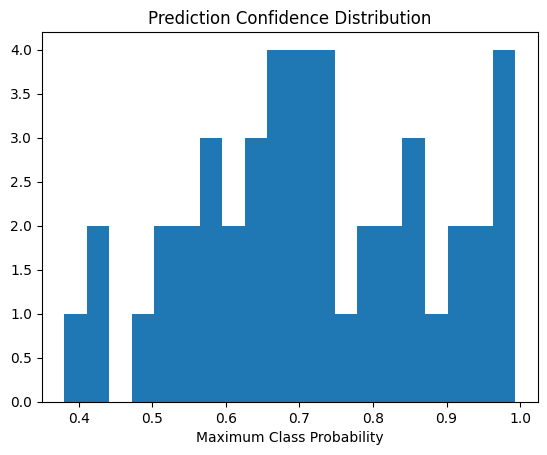

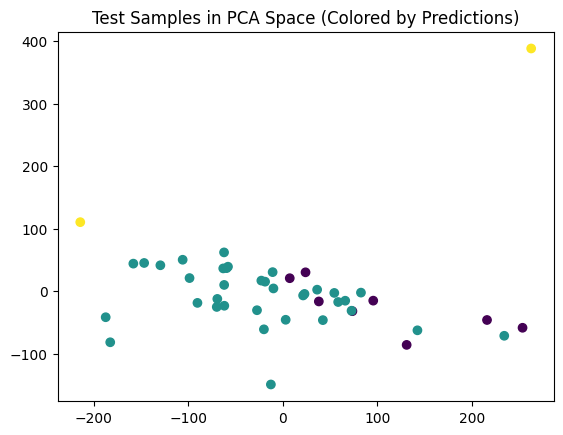

In [30]:
# Confidence histogram
plt.hist(np.max(y_pred, axis=1), bins=20)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Maximum Class Probability')
plt.show()

# PCA of test predictions
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
test_embeddings = pca.fit_transform(X_test_scaled)

plt.scatter(test_embeddings[:,0], test_embeddings[:,1], c=y_pred_classes)
plt.title('Test Samples in PCA Space (Colored by Predictions)')
plt.show()

In [31]:
# Early-Stage Detection Thresholding
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for malignant class
y_malignant_prob = final_model.predict(X_train_scaled)[:,2]

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_train == 2, y_malignant_prob)
optimal_idx = np.argmax(precision * recall)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal early-detection threshold: {optimal_threshold:.3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Optimal early-detection threshold: 0.036


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_22
Received: inputs=['Tensor(shape=(100, 30142))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_22
Received: inputs=['Tensor(shape=(200, 30142))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_22
Received: inputs=['Tensor(shape=(1, 30142))']
  

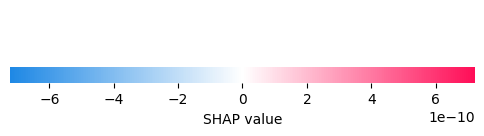

In [32]:
# Biomarker discovery
!pip install shap
import shap

# Create explainer
background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(final_model, background)

# Analyze a sample
shap_values = explainer.shap_values(X_test_scaled[:1])
shap.image_plot(shap_values, -X_test_scaled[:1], width=20)

Text(0.5, 1.0, 'Prediction Uncertainty Distribution')

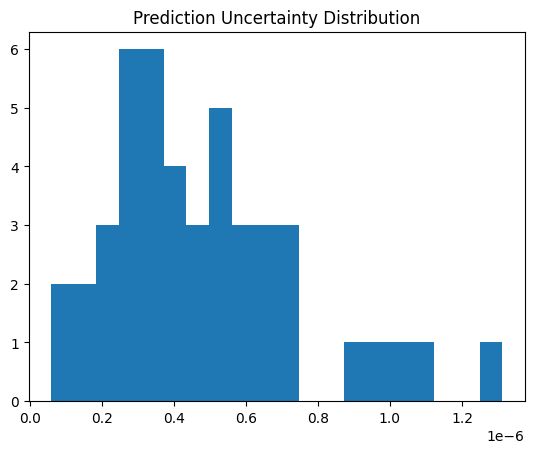

In [33]:
# Uncertainty Quantification
# Enable dropout at inference
mc_model = keras.models.clone_model(final_model)
mc_model.set_weights(final_model.get_weights())
mc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Get stochastic predictions
n_samples = 100
predictions = np.stack([mc_model.predict(X_test_scaled, verbose=0)
                        for _ in range(n_samples)])

# Calculate uncertainty
std_dev = np.std(predictions, axis=0)
plt.hist(std_dev.max(axis=1), bins=20)
plt.title('Prediction Uncertainty Distribution')